In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm
from tqdm import tqdm

from util import decode_npy_w

In [2]:
# relevant constants
DF = pd.read_csv('../data/main_table.csv')
FIGURE_PATH = '../figures'

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'

In [3]:
# plot fontsize settings

SMALL_FONT_SIZE = 22
MEDIUM_FONT_SIZE = 28
LARGE_FONT_SIZE = 28

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

In [8]:
BINSIZE_X, BINSIZE_Y = 1, 0.002
MIN_WVL, MAX_WVL = 400, 900

bin_centers_x = np.arange(MIN_WVL, MAX_WVL+1, BINSIZE_X)
bin_centers_y = np.arange(0.5, 1.50001, BINSIZE_Y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151556/151556 [01:58<00:00, 1281.40it/s]


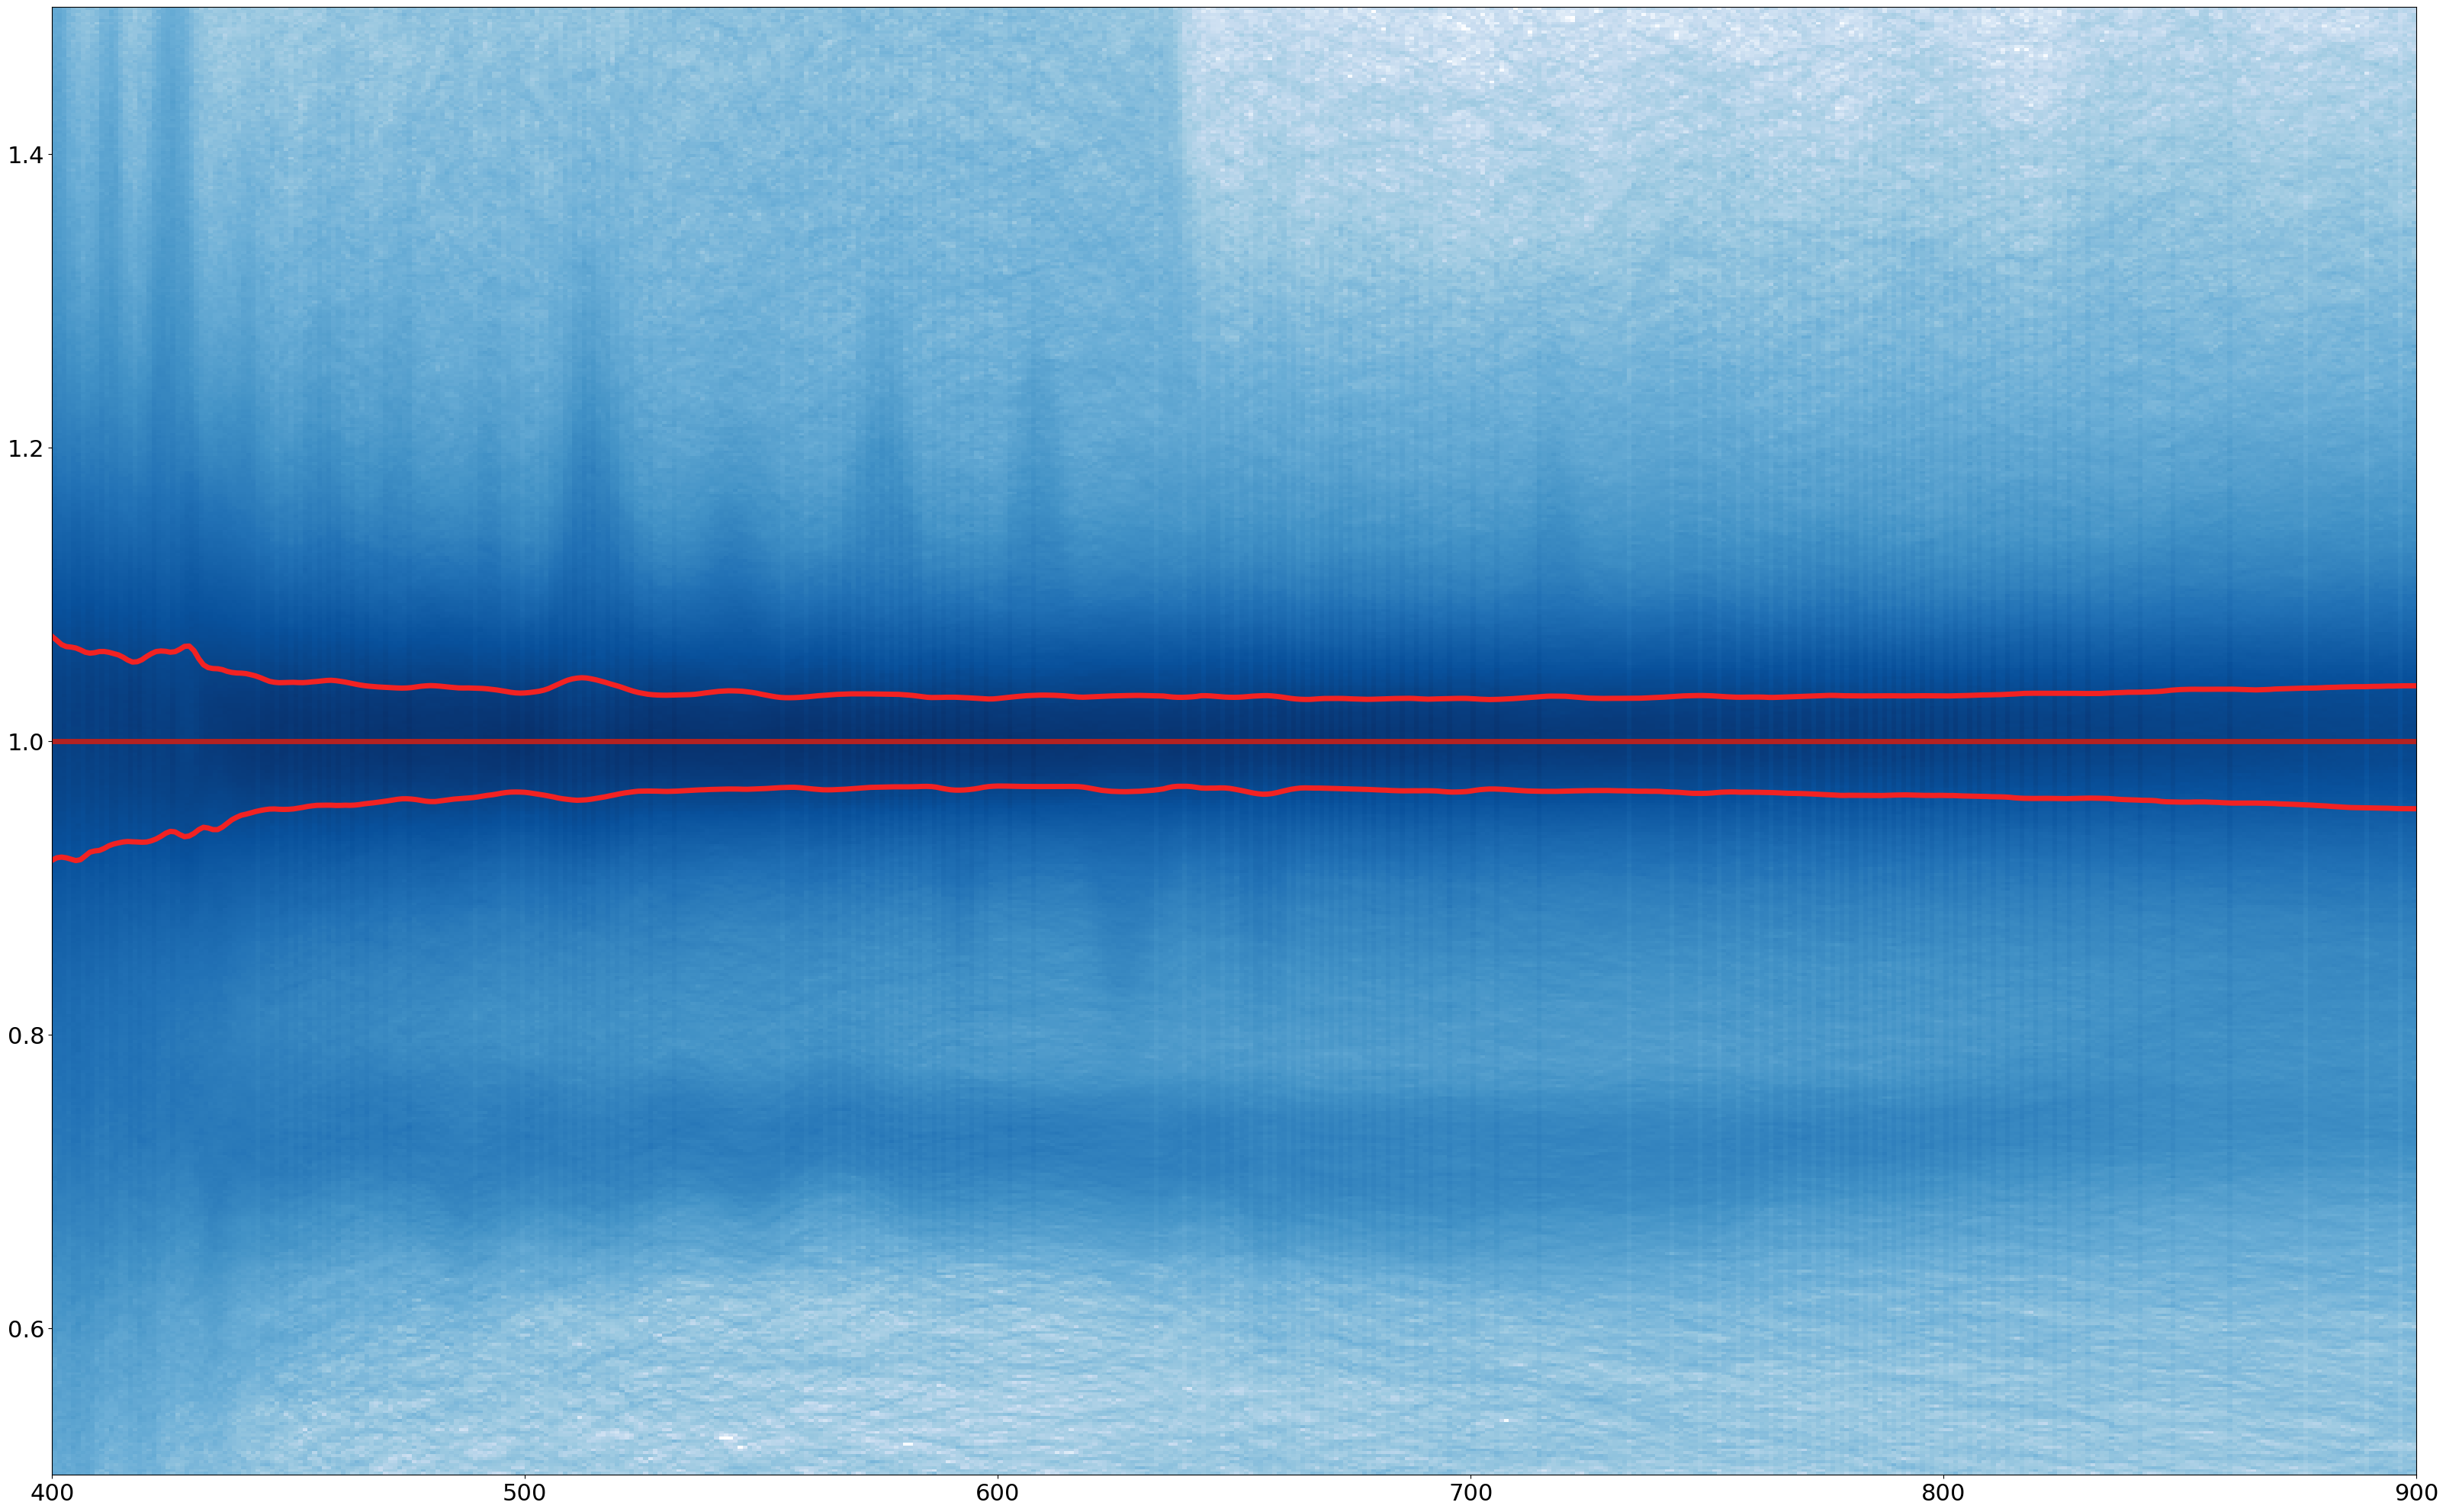

In [11]:
plt.figure(figsize=(40, 25))
plt.xlim(MIN_WVL, MAX_WVL)
plt.ylim(0.5, 1.5)
plt.axhline(1, c='#000000', lw=4, ls='--')

binned_ws = [ [] for _ in range(len(bin_centers_x)) ]
# flat_sampling, flat_ws = [], []
hist = np.zeros((len(bin_centers_y)-1, len(bin_centers_x)-1), dtype=np.float64)

for gaia_id in tqdm(DF[:][GAIA_ID_COLNAME]):
    try:
        sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
    except:
        print('Could not find an SDSS ID corresponding to the provided Gaia ID')
        continue

    try:
        spectra = decode_npy_w(f'../data/w/w_G{gaia_id}_S{sdss_id}.npy')
    except:
        continue
        
        
    sampling = spectra['sampling']
    ws = spectra['w']
    
    mask = (sampling > MIN_WVL) & (sampling < MAX_WVL)
    
    sampling = sampling[mask]
    ws = ws
    
#     flat_sampling.extend(sampling)
#     flat_ws.extend(ws)

    floors = np.floor(sampling).astype(np.int64)
    closer_to_higher = (sampling - floors) > 0.5

    indices = floors - MIN_WVL + closer_to_higher
    for i, w in zip(indices, ws):
        binned_ws[i].append(w)
        
    hist += np.histogram2d(sampling, ws, bins=(bin_centers_x, bin_centers_y))[0]


plt.pcolormesh(bin_centers_x, bin_centers_y, hist.T, cmap='Blues', norm=LogNorm())

w_median = [ np.median(v) for v in binned_ws ]
w_75 = [ np.quantile(v, 0.75) for v in binned_ws ]
w_25 = [ np.quantile(v, 0.25) for v in binned_ws ]

plt.plot(bin_centers_x, w_median, c='#b22222', lw=5, ls='-')
plt.plot(bin_centers_x, w_25, c='#f22222', lw=5, ls='-')
plt.plot(bin_centers_x, w_75, c='#f22222', lw=5, ls='-')